#  CE-40959: Deep Learning

## Homework 5 - 2:  EBGAN

The goal is to train a GAN with an auto-encoder as its discriminator.
For further information read the [paper of EBGAN](https://arxiv.org/abs/1609.03126).

Good luck

In [1]:
import numpy as np

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [3]:
# MNIST Dataset
original_train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
original_test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

In [4]:
cpu = True
BATCH_SIZE = 64
dropout_rate = 0.5

In [5]:
# Define Train loader
train_tensors = original_train_dataset.data.float() / 255
test_tensors = original_test_dataset.data.float() / 255

train_dataset = torch.utils.data.TensorDataset(train_tensors, original_train_dataset.targets)
test_dataset = torch.utils.data.TensorDataset(test_tensors, original_test_dataset.targets)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
def show(image_batch, rows=1):
    # Set Plot dimensions
    cols = np.ceil(image_batch.shape[0] / rows)
    plt.rcParams['figure.figsize'] = (0.0 + cols, 0.0 + rows) # set default size of plots
    
    for i in range(image_batch.shape[0]):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(image_batch[i], cmap="gray", vmin=0, vmax=1)
        plt.axis('off')
    plt.show()

---

In [8]:
class AutoEncoderMSE(nn.Module):
    def __init__(self, input_dim, encoder_dims, decoder_dims, dropout_rate):
        super(AutoEncoderMSE, self).__init__()
        
        self.input_dim = input_dim
        self.p = dropout_rate
        ########################## TODO ##########################
        # self.input_dropout must be a dropout module with p=dropout_rate
        pass
        ######################## END TODO ########################
        
        self.input_dropout = nn.Dropout(self.p)
        
        # Encoder part
        
        # encoder_layers = []
        
        ########################## TODO ##########################
        # Define encoder layers and add them to `encoder_layers`
        # Use nn.LeakyReLU(0.2) for activation functions
        pass
        
        self.encoder = nn.Sequential(
            
            nn.Linear(input_dim, encoder_dims[0]),
            nn.LeakyReLU(0.2),
            nn.Linear(encoder_dims[0], encoder_dims[1]),
            nn.LeakyReLU(0.2),
            nn.Linear(encoder_dims[1], encoder_dims[2]),
            nn.LeakyReLU(0.2)
        )
                
        last_encoder_dim = ([input_dim] + encoder_dims)[-1]

        # Decoder part
        #decoder_layers = []
        ########################## TODO ##########################
        # Define decoder layers and add them to `decoder_layers`
        # Use nn.LeakyReLU(0.2) for activation functions
        # Last layer does not need any activation function
        pass
        ######################## END TODO ########################
        
        
        self.decoder = nn.Sequential(
            nn.Linear(last_encoder_dim, decoder_dims[0]),
            nn.LeakyReLU(0.2),
            nn.Linear(decoder_dims[0], decoder_dims[1]),
            nn.LeakyReLU(0.2),
            nn.Linear(decoder_dims[1], self.input_dim)
        )
        
        self.MSE = nn.MSELoss(reduction='sum')

    def forward(self, x):
        ########################## TODO ##########################
        # Complete the flow
        # x > dropout > encoder > h > decoder > output > mse
        # Note that mse.shape = (batch_size, )
        # DO NOT FORGET TO ADD DROPOUT LAYER
        pass
    
        drop_outted = self.input_dropout(x)
        encoded = self.encoder(drop_outted)
        decoded = self.decoder(encoded)
        loss    = self.MSE(decoded,x)
            
            
        return loss, encoded

    
discriminator = AutoEncoderMSE(784, [256, 128, 64], [128, 256], dropout_rate=0.5)
print(discriminator)

AutoEncoderMSE(
  (input_dropout): Dropout(p=0.5)
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=256, out_features=784, bias=True)
  )
  (MSE): MSELoss()
)


In [9]:
def pullaway_loss(embeddings):
    norm = torch.sqrt(torch.sum(embeddings ** 2, -1, keepdim=True))
    normalized_emb = embeddings / norm
    similarity = torch.matmul(normalized_emb, normalized_emb.transpose(1, 0))
    batch_size = embeddings.size(0)
    loss_pt = (torch.sum(similarity) - batch_size) / (batch_size * (batch_size - 1))
    return loss_pt


In [10]:
generator = nn.Sequential(
    nn.Linear(128, 128),
    nn.LeakyReLU(0.2),
    nn.Linear(128, 256),
    nn.Dropout(),
    nn.LeakyReLU(0.2),
    nn.Linear(256, 512),
    nn.LeakyReLU(0.2),
    nn.Linear(512, 784),
    nn.Sigmoid()
)
print(generator)

Sequential(
  (0): Linear(in_features=128, out_features=128, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=128, out_features=256, bias=True)
  (3): Dropout(p=0.5)
  (4): LeakyReLU(negative_slope=0.2)
  (5): Linear(in_features=256, out_features=512, bias=True)
  (6): LeakyReLU(negative_slope=0.2)
  (7): Linear(in_features=512, out_features=784, bias=True)
  (8): Sigmoid()
)


In [11]:
if cpu:
    discriminator.cpu()
    generator.cpu()

In [12]:
LEARNING_RATE_D = 0.001
LEARNING_RATE_G = 0.001

opt_D = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE_D)
opt_G = optim.Adam(generator.parameters(), lr=LEARNING_RATE_G)

In [13]:
N_EPOCH = 100

epoch: 0 	 last batch loss D: 647.2991943359375 	 last batch loss G: 527.1735229492188


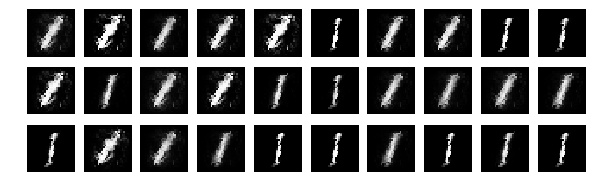

epoch: 1 	 last batch loss D: 612.4815673828125 	 last batch loss G: 526.3297119140625


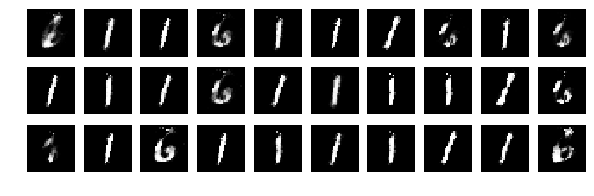

epoch: 2 	 last batch loss D: 595.334228515625 	 last batch loss G: 506.3877868652344


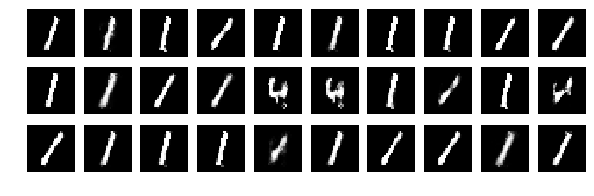

epoch: 3 	 last batch loss D: 485.27886962890625 	 last batch loss G: 517.825927734375


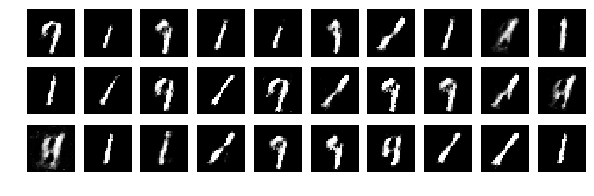

epoch: 4 	 last batch loss D: 534.6189575195312 	 last batch loss G: 485.95526123046875


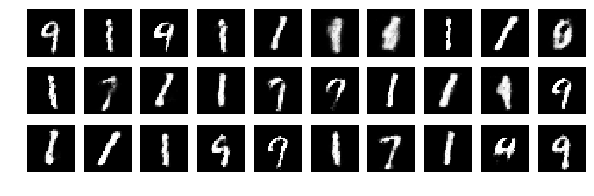

epoch: 5 	 last batch loss D: 475.38348388671875 	 last batch loss G: 485.17694091796875


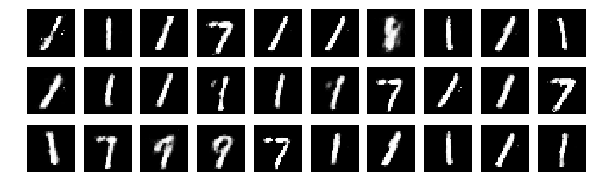

epoch: 6 	 last batch loss D: 508.7269592285156 	 last batch loss G: 536.1038818359375


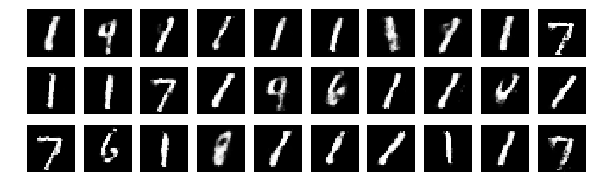

epoch: 7 	 last batch loss D: 492.2434387207031 	 last batch loss G: 468.8451232910156


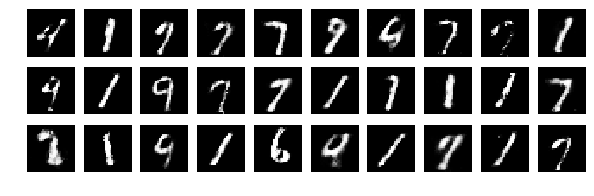

epoch: 8 	 last batch loss D: 503.305908203125 	 last batch loss G: 530.3807983398438


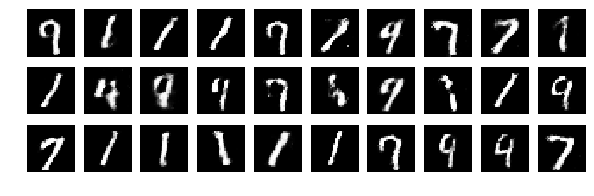

epoch: 9 	 last batch loss D: 462.5824279785156 	 last batch loss G: 694.2665405273438


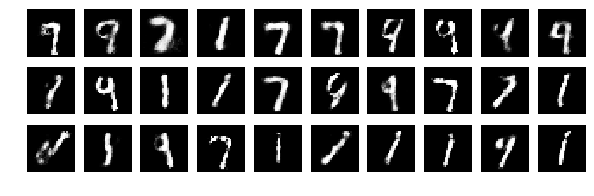

epoch: 10 	 last batch loss D: 482.060302734375 	 last batch loss G: 716.2938232421875


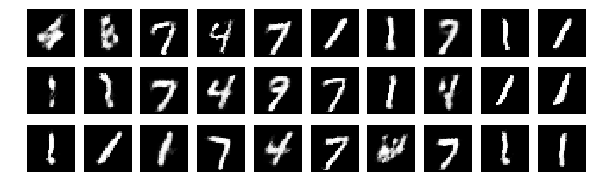

epoch: 11 	 last batch loss D: 523.5941162109375 	 last batch loss G: 673.2271728515625


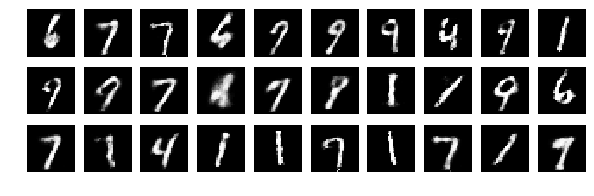

epoch: 12 	 last batch loss D: 529.385986328125 	 last batch loss G: 829.0928955078125


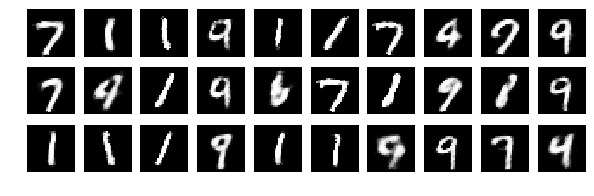

epoch: 13 	 last batch loss D: 493.24395751953125 	 last batch loss G: 573.82666015625


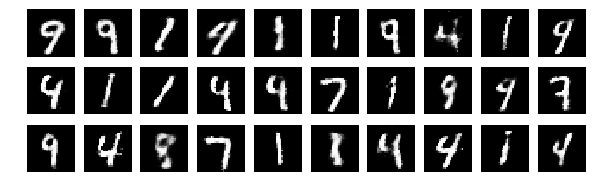

epoch: 14 	 last batch loss D: 549.4353637695312 	 last batch loss G: 510.16058349609375


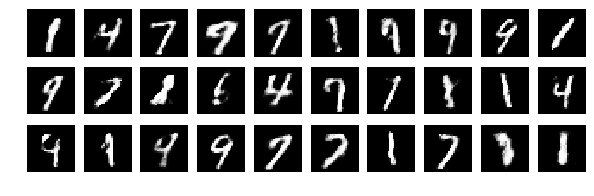

epoch: 15 	 last batch loss D: 458.4471435546875 	 last batch loss G: 559.4506225585938


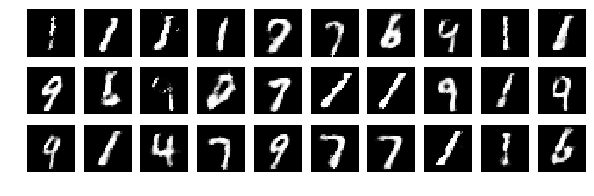

epoch: 16 	 last batch loss D: 475.35430908203125 	 last batch loss G: 582.6387329101562


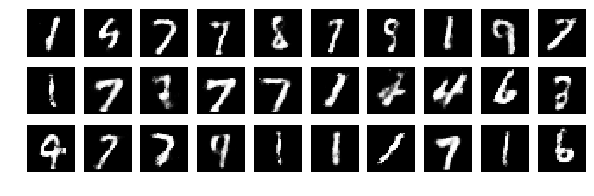

epoch: 17 	 last batch loss D: 484.76617431640625 	 last batch loss G: 543.4717407226562


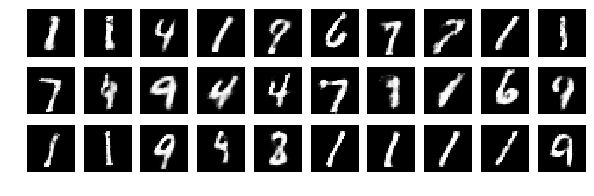

epoch: 18 	 last batch loss D: 439.6827697753906 	 last batch loss G: 661.4207153320312


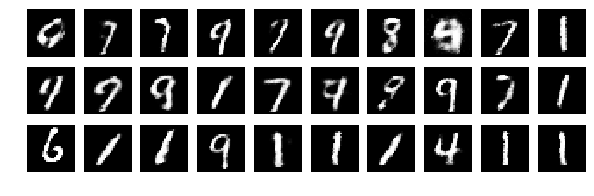

epoch: 19 	 last batch loss D: 516.6974487304688 	 last batch loss G: 450.0916442871094


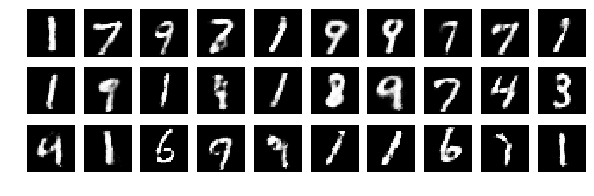

epoch: 20 	 last batch loss D: 439.929931640625 	 last batch loss G: 571.2946166992188


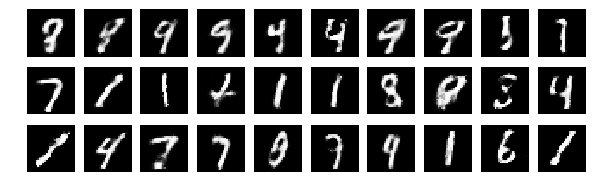

KeyboardInterrupt: 

In [14]:
m = 16
lambda_pt = 0.1

for epoch in range(N_EPOCH):
    for i, (img, label) in enumerate(train_loader):
        img = img.flatten(start_dim = 1)

        real_img = img
        if cpu:
            real_img = real_img.cpu()

        z = torch.randn(img.shape[0], 128)
        if cpu:
            z = z.cpu()
        fake_img = generator(z)
        
        # Generator Part
        opt_G.zero_grad()
        ########################## TODO ##########################
        # Define loss for generator
        pass
        #g_loss = d_loss_fake
        loss_g ,encoded = discriminator(fake_img) 
        loss_g += lambda_pt * pullaway_loss(encoded)
        loss_g.backward()
        opt_G.step()
        

        # Discriminator Part
        opt_D.zero_grad()
        ########################## TODO ##########################
        # Define loss for discriminator
        pass
        d_loss_real,_ = discriminator(img)
        d_loss_fake,_ = discriminator(fake_img.detach())
        
        loss_d = d_loss_real
        if (m*img.shape[0] - d_loss_fake.data).item() > 0:
            loss_d += m*img.shape[0] - d_loss_fake
            
        loss_d.backward()
        opt_D.step()
        
        
        

    
    print("epoch: {} \t last batch loss D: {} \t last batch loss G: {}".format(epoch, loss_d.item(), loss_g.item()))
    imgs_to_show = fake_img[:30].view(-1, 28, 28).detach().cpu().numpy()
    show(imgs_to_show, rows=3)
